In [360]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.sparse.linalg import norm
from scipy.linalg import eigh_tridiagonal
from sklearn.cluster import KMeans

### Lanczos

In [442]:
def Lanczos_step( A, T, Q, m0 = 0, m = 20):
    """
    Lanczos method implementation
    m0 - Z_ini
    m - Z_ini + Z_aug
    """
    v    = Q[0, :]
    w0   = A.dot( v )
    alfa = np.dot( w0.T, v )
    w    = w0 - np.dot( alfa, v )
    
    for j in range( m0, m - 1 ):
        beta = np.linalg.norm( w )
        v0   = v
        v    = w / beta
        w0   = A.dot( v )
        alfa = np.dot( w0.T, v )
        w    = w0 - np.dot( alfa, v ) - np.dot( beta, v0 )
        T[j, j]     = alfa
        T[j, j + 1] = beta
        T[j + 1, j] = beta
        Q[j, :]     = v
    
    beta = np.linalg.norm( w )
    v0   = v
    v    = w / beta
    w0   = A.dot( v )
    alfa = np.dot( w0.T, v )
    w    = w0 - np.dot( alfa, v ) - np.dot( beta, v0 )
    T[m - 1, m - 1] = alfa
    Q[m - 1, :]     = v
    
    return T, Q

### Lanczos-IO

In [560]:
## input:
#      M - real symmetric matrix
#      Z_ini - # of initial Lanczos vectors
#      Z_aug - # of augmented Lanczos vectors
## output
#      evals, evecs - K-leading eigenpairs
def Lanczos_IO( M, T, Q, K_min, Z_ini = 20, Z_aug = 10, rule_of_stop = None ):
    """Lanczos-IO algorithm (2) implementation"""
    K    = 1
    Flag = 1
    n    = M.shape[0]
    Z = 0
    
    v0 = np.random.rand( n )
    v0 = v0 / np.linalg.norm( v0 )
    v = np.array(L.todense()).dot( v0 ).flatten()
    v = v - np.dot( v, v0 ) * v0
    v = v / np.linalg.norm( v )

    T, Q = np.zeros( (Z_ini, Z_ini) ), np.zeros( (Z_ini, n) )
    Q[0, :] = v
    lead_evals, lead_evecs = np.zeros( K_min ), np.zeros( (K_min, n) )
    
    while Flag == 1:
        T_new, Q_new = Lanczos_step( L, T, Q, m0 = Z, m = Z_ini )
        diag                   = T_new.diagonal()
        off_diag               = T_new.diagonal(1)
        real_evals, real_evecs = eigh_tridiagonal( diag, off_diag )
        
        error = abs( np.dot( T[Z_ini - 2, Z_ini - 1], real_evecs[Z_ini - 1, K - 1] ) )
        tolerance = np.finfo(np.float64).eps * norm( M, ord = np.inf )
        
        print( "Residual error: {}".format( error - tolerance ) )
        
        if error > tolerance:
            Z = Z_ini
            Z_ini = Z_ini + Z_aug
            T_new.resize( (Z_ini, Z_ini), refcheck = False )
            Q_new.resize( (Z_ini, n), refcheck = False )
            continue
        
        if K >= K_min or rule_of_stop is not None and rule_of_stop( T_new, Q_new ) == False:
            Flag = 0
        else:
            lead_evals = np.dot( real_evals[1:K], Q_new[1:K, :] )
            lead_evecs[K - 1] = Q_new[K, :]
            
            K = K + 1
            continue
    
    return lead_evals, lead_evecs, K

### Clusterization

In [432]:
def Spectral_Clusterization_IO(evecs, current_cluster_cnt):
    kmeans_partition = KMeans(n_clusters = current_cluster_cnt, random_state=0).fit(evecs).labels_
    # create input of a quality function (communities - further rule_of_stop argument)
    communities = {i:set() for i in range(current_cluster_cnt)}
    for idx, cluster_num in enumerate(kmeans_partition):
        communities[cluster_num].add(idx)
    communities = list(communities.values())
    
    return kmeans_partition

## Tests

### Lanczos

In [517]:
L = np.array( [ [2., -1, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, 2, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, -1, 3, -1, 0, 0, 0, 0, 0, 0],
                [0, 0, -1, 4, -1, 0, -1, 0, 0, -1],
                [0, 0, 0, -1, 4, -1, -1, -1, 0, 0],
                [0, 0, 0, 0, -1, 3, -1, -1, 0, 0],
                [0, 0, 0, -1, -1, -1, 6, -1, -1, -1],
                [0, 0, 0, 0, -1, -1, -1, 4, 0, -1],
                [0, 0, 0, 0, 0, 0, -1, 0, 2, -1],
                [0, 0, 0, -1, 0, 0, -1, -1, -1, 4] ] )

real_evals, real_evecs = np.linalg.eig(L)
real_evals.sort()

print(real_evals)

[-1.11022302e-16  3.06851215e-01  1.72406597e+00  2.81086785e+00
  3.00000000e+00  3.78467863e+00  4.33735483e+00  4.84264371e+00
  6.14394237e+00  7.04959542e+00]


In [518]:
L = sparse.csr_matrix( L )

v0 = np.random.rand( 10 )
v0 = v0 / np.linalg.norm( v0 )
v = np.array(L.todense()).dot( v0 ).flatten()
v = v - np.dot( v, v0 ) * v0
v = v / np.linalg.norm( v )

T, Q = np.zeros( (10, 10) ), np.zeros( (10, 10) )
Q[0, :] = v

T_new, Q_new = Lanczos_step( L, T, Q, m0 = 0, m = 10 )
diag = T_new.diagonal()
off_diag = T_new.diagonal(1)
real_evals2, real_evecs2 = eigh_tridiagonal( diag, off_diag )
real_evals2.sort()

print( real_evals2 )

[0.14077318 0.55134284 1.12582497 2.06956777 3.03330987 3.47316735
 3.87753471 4.88320601 5.94628938 7.31582173]


In [509]:
print( real_evals - real_evals2 )

[-0.3237503  -0.15196759  0.35482166  0.19680602 -0.02887586  0.10380772
 -0.98535147 -0.89932266 -0.86134791 -0.26666017]


### Lanczos_IO

Number of vertices = 34
Number of edges = 78


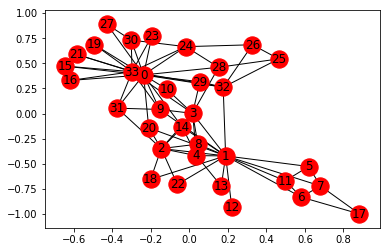

In [555]:
kn = nx.read_gml("karate.gml")

print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))

nx.draw_networkx(kn)

In [561]:
A = nx.adjacency_matrix(kn)
L = sparse.diags(np.ravel(A.sum(0))).tocsr() - A

K = 3

real_evals3, vectors, current_cluster_cnt = Lanczos_IO( L, T, Q, 3 )
real_evals3.sort()

print( vectors )

Residual error: 8.895780231385819e-06
Residual error: -7.549516567451064e-15
Residual error: -7.549516567451064e-15
Residual error: -7.549516567451064e-15
[[-0.47578304 -0.22589439  0.0293473  -0.56477369  0.10899947 -0.052056
  -0.01548279 -0.17710856 -0.08322947  0.0807448  -0.010314   -0.14570939
  -0.11744133 -0.12270217 -0.08949296 -0.0305478  -0.03042147 -0.12083952
  -0.10958924 -0.03532946 -0.07495851 -0.03171355 -0.09613428 -0.02347502
   0.10972985 -0.11503602 -0.1532883  -0.03219345 -0.03222643 -0.0295126
  -0.13656606 -0.06512027  0.08538505 -0.39610237]
 [-0.13456296  0.13135573  0.16019085 -0.14353311 -0.1682672  -0.01431241
  -0.26735028  0.29324006  0.07303261  0.04178685  0.09049093  0.14839004
   0.02927666  0.09967726  0.23709002  0.11167346  0.11209763  0.06462034
   0.01363995  0.09561839  0.12344445  0.10775929  0.05881679  0.13542128
  -0.19974185  0.09124253  0.09943054 -0.08229655  0.07428244  0.18644922
   0.50124916 -0.0274081  -0.01899924 -0.4282322 ]
 [ 0. 

In [557]:
kmeans_partition = Spectral_Clusterization_IO( vectors.T, current_cluster_cnt )
print( kmeans_partition )

[2 2 2 1 1 2 2 0 0 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 1]


/Users/farewell/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


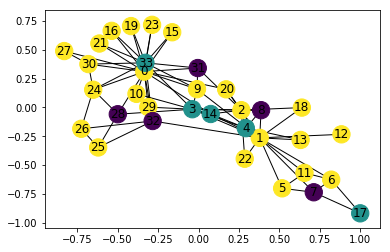

In [558]:
nx.draw_networkx( kn, node_color = kmeans_partition )